# Humidity Quantiles
Looks at how the bucket depth, specific humidity and relative humidity vary between climates for different evaporative fractions

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-05-15 16:25:22,371 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'bucket_depth']        # only keep variables required to compute relative humidity and MSE
# Load dataset
exp_dir = 'tau_sweep/land/meridional_band/'
exp_names = ["bucket/k=1", "bucket/k=1_5", "bucket_evap/evap=0_1/k=1", "bucket_evap/evap=0_1/k=1_5"]
n_exp = len(exp_names)
n_evap = 2              # number of different evaporative fractions used
n_kappa = 2             # number of different kappa used for each evap fraction
evap_ind = [[0, 1], [2,3]]      # evap_ind[0] is ds indices corresponding to first evap fraction

ds = []
albedo = []
tau_sw = []
tau_lw = []
evap_param = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        evap_param += [namelist['surface_flux_nml']['land_evap_prefactor']]
    except KeyError:
        print(f'Experiment {i}: Evap param not specified so set to default value of 1')
        evap_param += [1]

max_bucket_depth_land = namelist['idealized_moist_phys_nml']['max_bucket_depth_land']
tau_lw_ref = tau_lw[0]
tau_lw_warm = tau_lw[1]

Experiment 0: Evap param not specified so set to default value of 1
Experiment 1: Evap param not specified so set to default value of 1


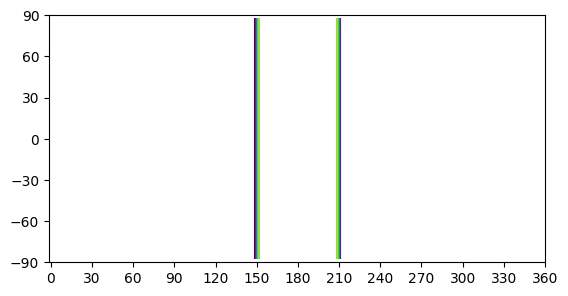

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get one dataset, `ds_quant`, for land, for each latitude bin averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the ocean summer for a given latitude bin.

In [4]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2
# Tropics
lat_min = 0
lat_max = 20
# Extratropics
# lat_min = 30
# lat_max = 60

ds_all = {'land':[], 'ocean': []}
ds_summer = []
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in ['land', 'ocean']:
            ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
            ds_use = ds_use.sel(lon=np.unique(lon[surf]), method='nearest')
            ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
            ds_all[surf] += [ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))]
            ds_all[surf][i].load()
            if surf == 'ocean':
                ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
                ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
                # Combine hemispheres and average over longitude, time and latitude.
                ds_use = xr.concat([ds_nh_summer, ds_sh_summer], dim='lat')
                ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
                ds_summer += [ds_use]
                ds_summer[i].load()
            pbar.update(1)

100%|██████████| 8/8 [01:06<00:00,  8.28s/it]


## Bucket Depth
This looks at how the average bucket depth varies when averaged over different temperature percentiles.

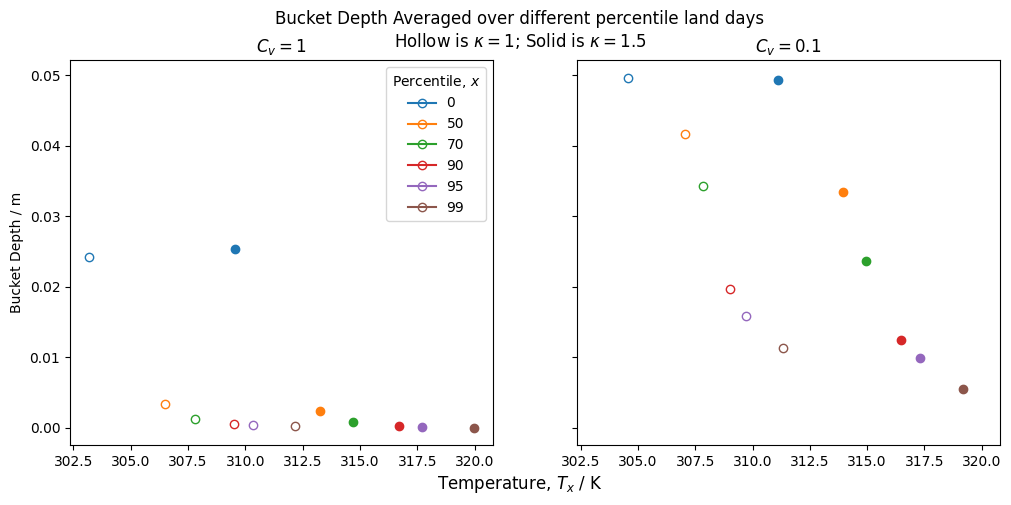

In [5]:
# Plot mean bucket depth averaged over different quantiles of land surface temperature
def get_quant_ind(dataset, percentile):
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh = dataset.temp.quantile(percentile/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(dataset.temp > quantile_thresh)[0]
    return quant_ind

quant_plot = np.concatenate([[0], np.arange(50, 100, 20), [95, 99]])
fig, ax = plt.subplots(1,n_evap, figsize=(12, 5), sharey=True, sharex=True)
for i in range(n_evap):
    for j, quant in enumerate(quant_plot):
        for k in range(n_kappa):
            use_ind = get_quant_ind(ds_all['land'][evap_ind[i][k]], quant)
            temp_mean = np.mean(ds_all['land'][evap_ind[i][k]].temp[use_ind])
            bucket_depth_mean = np.mean(ds_all['land'][evap_ind[i][k]].bucket_depth[use_ind])
            if k == 0:
                ax[i].plot(temp_mean, bucket_depth_mean, marker='o', fillstyle='none', label=quant,
                           color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])
            else:
                ax[i].plot(temp_mean, bucket_depth_mean, marker='o',
                           color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])
        ax[i].set_title(f'$C_v={evap_param[evap_ind[i][0]]}$')
ax[0].legend(title='Percentile, $x$')
fig.supxlabel('Temperature, $T_x$ / K')
ax[0].set_ylabel('Bucket Depth / m')
fig.suptitle('Bucket Depth Averaged over different percentile land days\n'
             f'Hollow is $\kappa = {tau_lw_ref}$; Solid is $\kappa={tau_lw_warm}$');

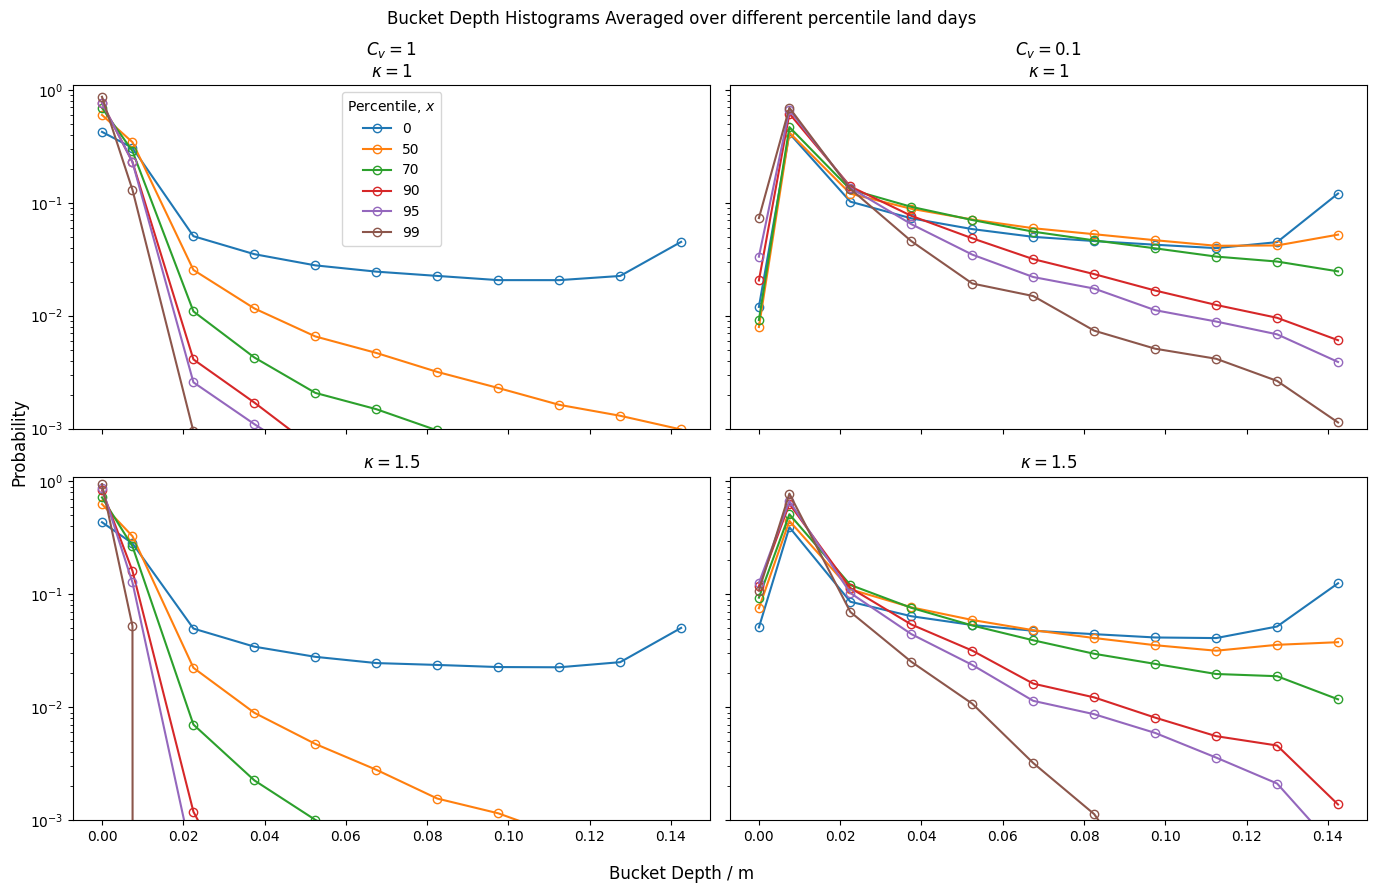

In [6]:
# Plot bucket depth histograms averaged over different quantiles of land surface temperature
n_bins = 10
# Have first bin be very narrow and centered on 0 so records amount of 0 bucket depths
bins = np.concatenate([[-max_bucket_depth_land/1e5, max_bucket_depth_land/1e5],
                       np.linspace(max_bucket_depth_land/n_bins, max_bucket_depth_land, n_bins)])
bin_centres = np.convolve(bins, np.ones(2)/2, mode='valid')
fig, ax = plt.subplots(n_kappa,n_evap, figsize=(14, 9), sharex=True, sharey=True)
for i in range(n_evap):
    for quant in quant_plot:
        for k in range(n_kappa):
            bin_counts = np.histogram(ds_all['land'][evap_ind[i][k]].bucket_depth[
                                          get_quant_ind(ds_all['land'][evap_ind[i][k]], quant)], bins=bins)[0]
            ax[k, i].plot(bin_centres, bin_counts/np.sum(bin_counts), marker='o', fillstyle='none', label=quant)
            if k == 0:
                ax[k, i].set_title(f"$C_v={evap_param[evap_ind[i][0]]}$\n$\kappa = {tau_lw[evap_ind[0][k]]}$")
            else:
                ax[k, i].set_title(f"$\kappa = {tau_lw[evap_ind[0][k]]}$")
ax[0,0].set_yscale('log')
ax[0, 0].legend(title='Percentile, $x$')
fig.supylabel('Probability')
fig.supxlabel('Bucket Depth / m')
fig.suptitle('Bucket Depth Histograms Averaged over different percentile land days')
ax[0,0].set_ylim([1e-3, 1.1])
plt.tight_layout();

## Specific Humidity


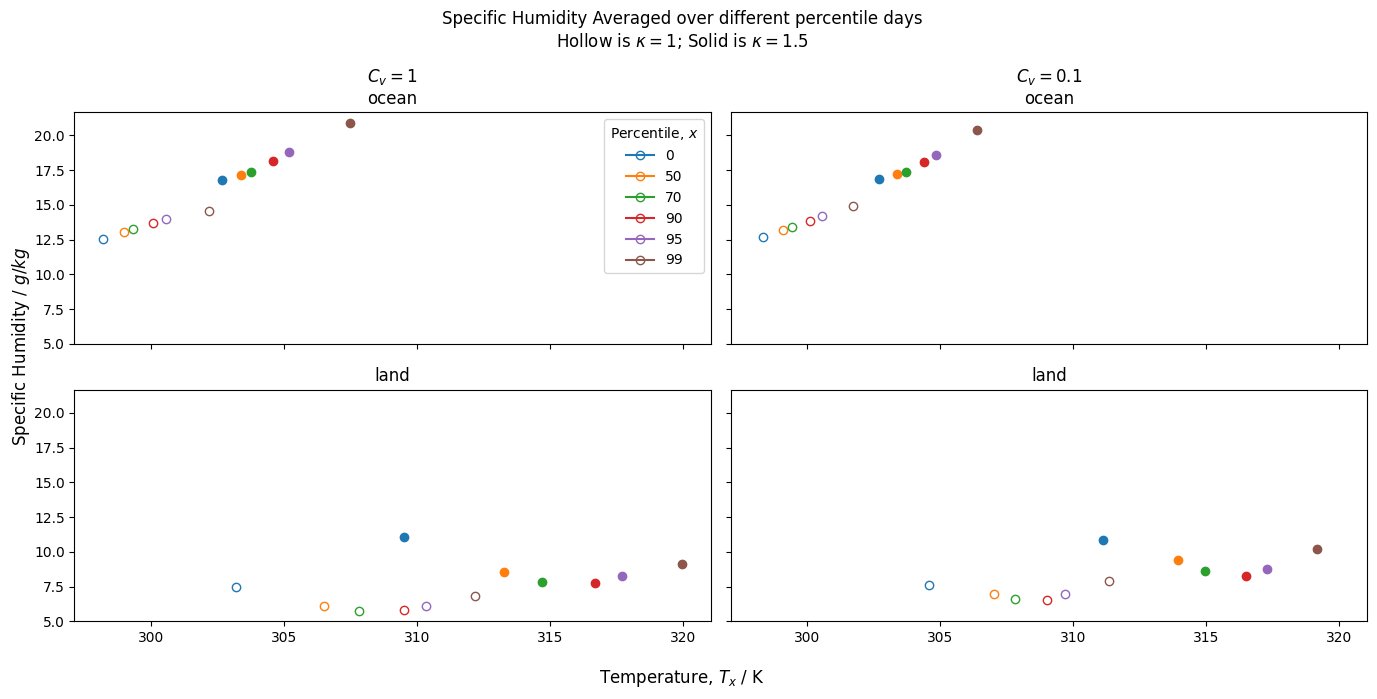

In [7]:
surfaces = ['ocean', 'land']
fig, ax = plt.subplots(len(surfaces),n_evap, figsize=(14, 7), sharex=True, sharey=True)
temp_quant = {'ocean': np.zeros((n_exp, len(quant_plot))), 'land': np.zeros((n_exp, len(quant_plot)))}
sphum_quant = {'ocean': np.zeros((n_exp, len(quant_plot))), 'land': np.zeros((n_exp, len(quant_plot)))}
for s, ds_use in enumerate([ds_summer, ds_all['land']]):
    for i in range(n_evap):
        for j, quant in enumerate(quant_plot):
            for k in range(n_kappa):
                use_ind = get_quant_ind(ds_use[evap_ind[i][k]], quant)
                temp_quant[surfaces[s]][evap_ind[i][k], j] = np.mean(ds_use[evap_ind[i][k]].temp[use_ind])
                sphum_quant[surfaces[s]][evap_ind[i][k], j] = np.mean(ds_use[evap_ind[i][k]].sphum[use_ind])
                if k == 0:
                    ax[s, i].plot(temp_quant[surfaces[s]][evap_ind[i][k], j], 1000 * sphum_quant[surfaces[s]][evap_ind[i][k], j],
                                  marker='o', fillstyle='none', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
                                  label=quant)
                else:
                    ax[s, i].plot(temp_quant[surfaces[s]][evap_ind[i][k], j], 1000 * sphum_quant[surfaces[s]][evap_ind[i][k], j],
                                  marker='o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])
            if s == 0:
                ax[s, i].set_title(f"$C_v={evap_param[evap_ind[i][0]]}$\n{surfaces[s]}")
            else:
                ax[s, i].set_title(f"{surfaces[s]}")
ax[0, 0].legend(title='Percentile, $x$')
fig.supxlabel('Temperature, $T_x$ / K')
fig.supylabel('Specific Humidity / $g/kg$')
fig.suptitle(f'Specific Humidity Averaged over different percentile days\n'
             f'Hollow is $\kappa = {tau_lw_ref}$; Solid is $\kappa={tau_lw_warm}$')
plt.tight_layout();

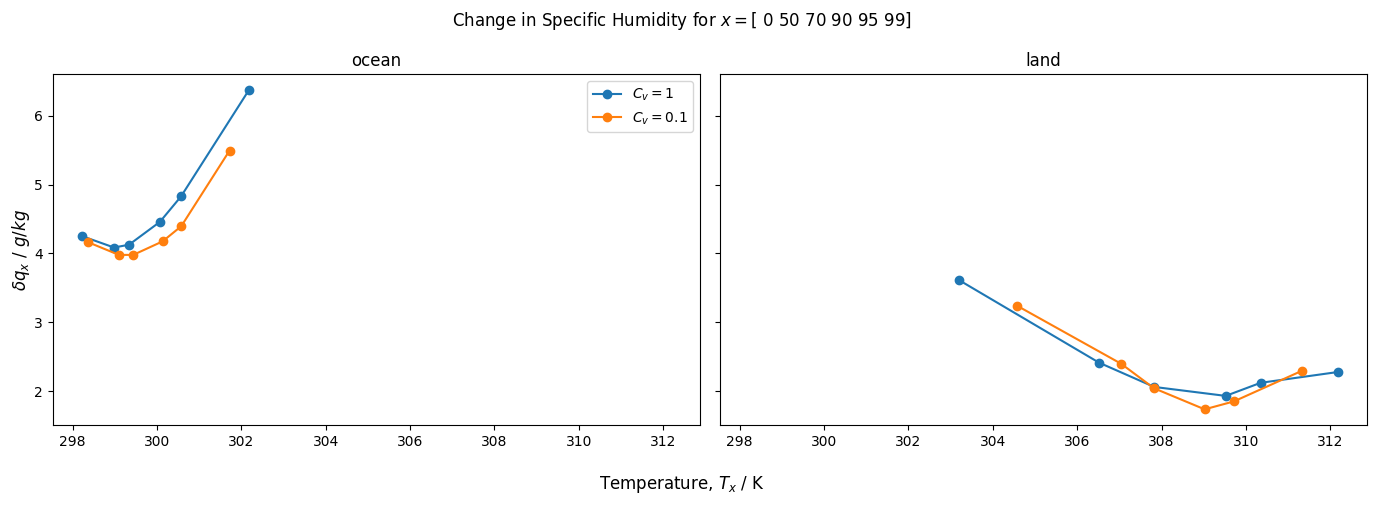

In [8]:
# Plot change in specific humidity for each quantile
fig, ax = plt.subplots(1,len(surfaces), figsize=(14, 5), sharex=True, sharey=True)
for s, surf in enumerate(surfaces):
    for i in range(n_evap):
        ax[s].plot(temp_quant[surf][evap_ind[i][0]], 1000 * (sphum_quant[surf][evap_ind[i][1]]-sphum_quant[surf][evap_ind[i][0]]),
                   marker='o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
                   label=f"$C_v={evap_param[evap_ind[i][0]]}$")
        ax[s].set_title(f"{surfaces[s]}")
fig.supylabel('$\delta q_x$ / $g/kg$')
fig.supxlabel('Temperature, $T_x$ / K')
fig.suptitle(f'Change in Specific Humidity for $x=${quant_plot}')
ax[0].legend()
plt.tight_layout();

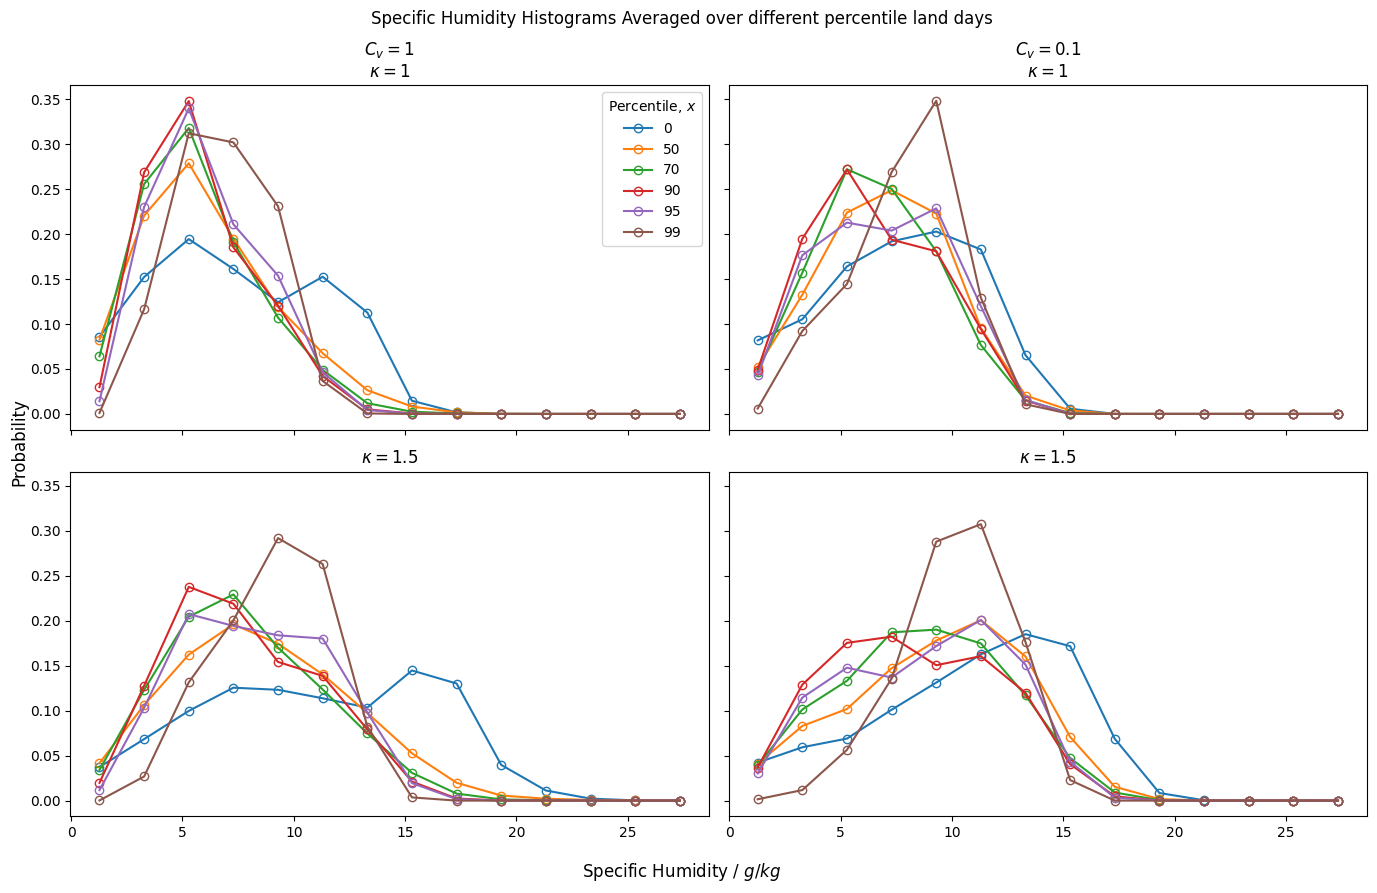

In [9]:
# Plot specific humidity histograms averaged over different quantiles of land surface temperature
min_sphum = np.min([ds_all['land'][i].sphum.min() for i in range(n_exp)])
max_sphum = np.max([ds_all['land'][i].sphum.max() for i in range(n_exp)])
sphum_bins = np.linspace(min_sphum, max_sphum, 15)

fig, ax = plt.subplots(n_kappa,n_evap, figsize=(14, 9), sharex=True, sharey=True)
for i in range(n_evap):
    for quant in quant_plot:
        for k in range(n_kappa):
            bin_counts = np.histogram(ds_all['land'][evap_ind[i][k]].sphum[
                                          get_quant_ind(ds_all['land'][evap_ind[i][k]], quant)], bins=sphum_bins)[0]
            ax[k, i].plot(np.convolve(sphum_bins, np.ones(2)/2, mode='valid') * 1000, bin_counts/np.sum(bin_counts),
                          marker='o', fillstyle='none', label=quant)
            if k == 0:
                ax[k, i].set_title(f"$C_v={evap_param[evap_ind[i][0]]}$\n$\kappa = {tau_lw[evap_ind[0][k]]}$")
            else:
                ax[k, i].set_title(f"$\kappa = {tau_lw[evap_ind[0][k]]}$")

ax[0, 0].legend(title='Percentile, $x$')
fig.supylabel('Probability')
fig.supxlabel('Specific Humidity / $g/kg$')
fig.suptitle('Specific Humidity Histograms Averaged over different percentile land days')
plt.tight_layout();

## Relative Humidity

The plots below show that with $C_v=1$ that the relative humidity over land decreases with warming for all percentiles $x$ with $C_v=0.1$ as we see with more sophisticated climate models.

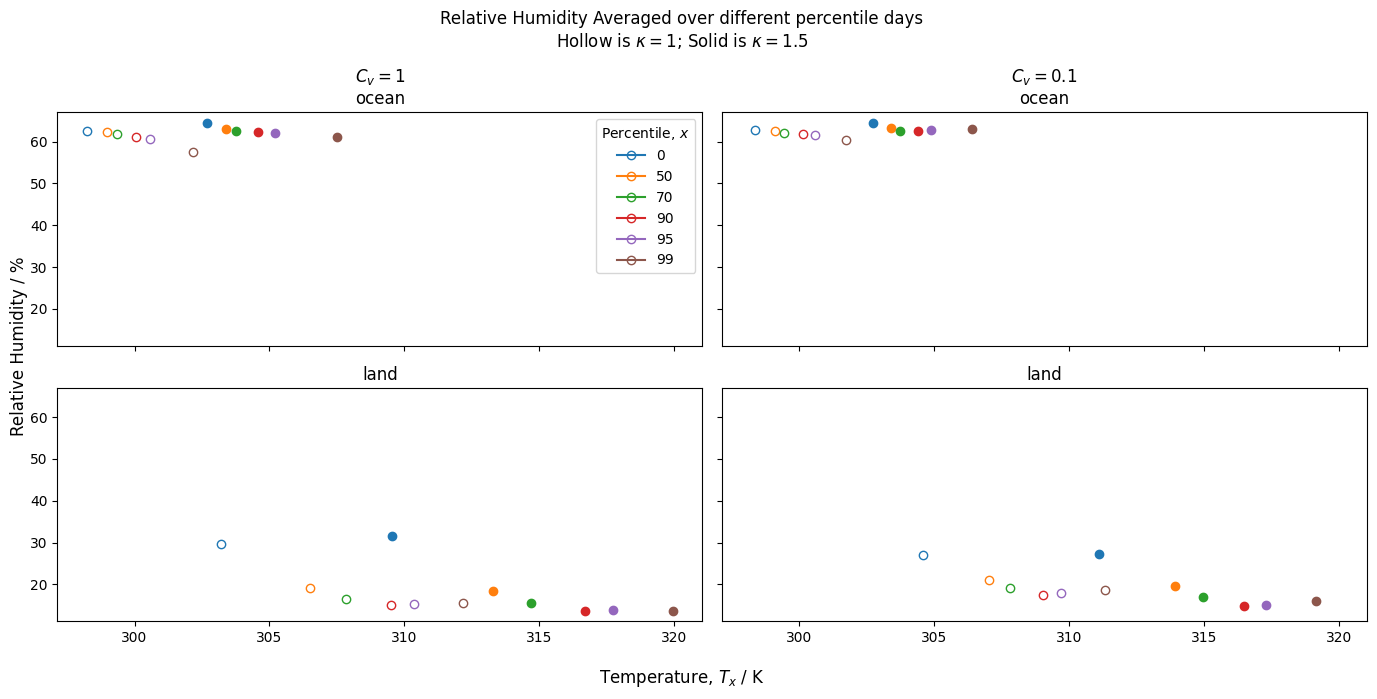

In [10]:
# Compute relative humidity on each individual day and then average over these
# Rather than computing relative humidity from average temperature and average sphum
p_surface = float(ds_summer[0].pfull) * 100
rh_all = {'ocean': [rh_from_sphum(ds_summer[i].sphum, ds_summer[i].temp, p_surface).to_numpy() for i in range(n_exp)],
          'land': [rh_from_sphum(ds_all['land'][i].sphum, ds_all['land'][i].temp, p_surface).to_numpy() for i in range(n_exp)]}
rh_quant = {'ocean': np.zeros((n_exp, len(quant_plot))), 'land': np.zeros((n_exp, len(quant_plot)))}

fig, ax = plt.subplots(len(surfaces),n_evap, figsize=(14, 7), sharex=True, sharey=True)
for s, ds_use in enumerate([ds_summer, ds_all['land']]):
    for i in range(n_evap):
        for j, quant in enumerate(quant_plot):
            for k in range(n_kappa):
                use_ind = get_quant_ind(ds_use[evap_ind[i][k]], quant)
                rh_quant[surfaces[s]][evap_ind[i][k], j] = np.mean(rh_all[surfaces[s]][evap_ind[i][k]][use_ind])
                if k == 0:
                    ax[s, i].plot(temp_quant[surfaces[s]][evap_ind[i][k], j], rh_quant[surfaces[s]][evap_ind[i][k], j],
                                  marker='o', fillstyle='none', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
                                  label=quant)
                else:
                    ax[s, i].plot(temp_quant[surfaces[s]][evap_ind[i][k], j], rh_quant[surfaces[s]][evap_ind[i][k], j],
                                  marker='o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])
            if s == 0:
                ax[s, i].set_title(f"$C_v={evap_param[evap_ind[i][0]]}$\n{surfaces[s]}")
            else:
                ax[s, i].set_title(f"{surfaces[s]}")
ax[0, 0].legend(title='Percentile, $x$')
fig.supxlabel('Temperature, $T_x$ / K')
fig.supylabel('Relative Humidity / %')
fig.suptitle(f'Relative Humidity Averaged over different percentile days\n'
             f'Hollow is $\kappa = {tau_lw_ref}$; Solid is $\kappa={tau_lw_warm}$')
plt.tight_layout();

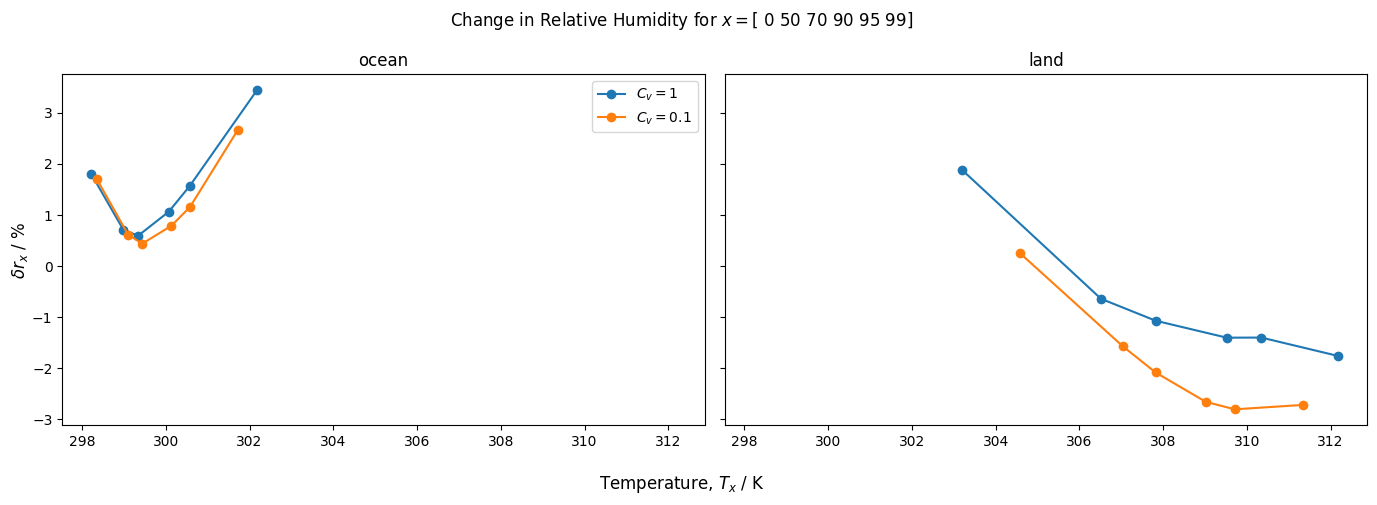

In [11]:
# Plot change in relative humidity for each quantile
fig, ax = plt.subplots(1,len(surfaces), figsize=(14, 5), sharex=True, sharey=True)
for s, surf in enumerate(surfaces):
    for i in range(n_evap):
        ax[s].plot(temp_quant[surf][evap_ind[i][0]], rh_quant[surf][evap_ind[i][1]]-rh_quant[surf][evap_ind[i][0]],
                   marker='o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
                   label=f"$C_v={evap_param[evap_ind[i][0]]}$")
        ax[s].set_title(f"{surfaces[s]}")
fig.supylabel('$\delta r_x$ / %')
fig.supxlabel('Temperature, $T_x$ / K')
fig.suptitle(f'Change in Relative Humidity for $x=${quant_plot}')
ax[0].legend()
plt.tight_layout();



# fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True, sharey=True)
# ax.plot(temp_quant['ocean'][0], rh_quant['ocean'][1]-rh_quant['ocean'][0], marker='o', color='blue', label='ocean - summer')
# ax.plot(temp_quant['land'][0], rh_quant['land'][1]-rh_quant['land'][0], marker='o', color='red', label='land')
# ax.set_ylabel('$\delta r_x$ / %')
# ax.set_xlabel('Temperature, $T_x$ / K')
# ax.set_title(f'Change in Relative Humidity for $x=${quant_plot}')
# ax.legend();

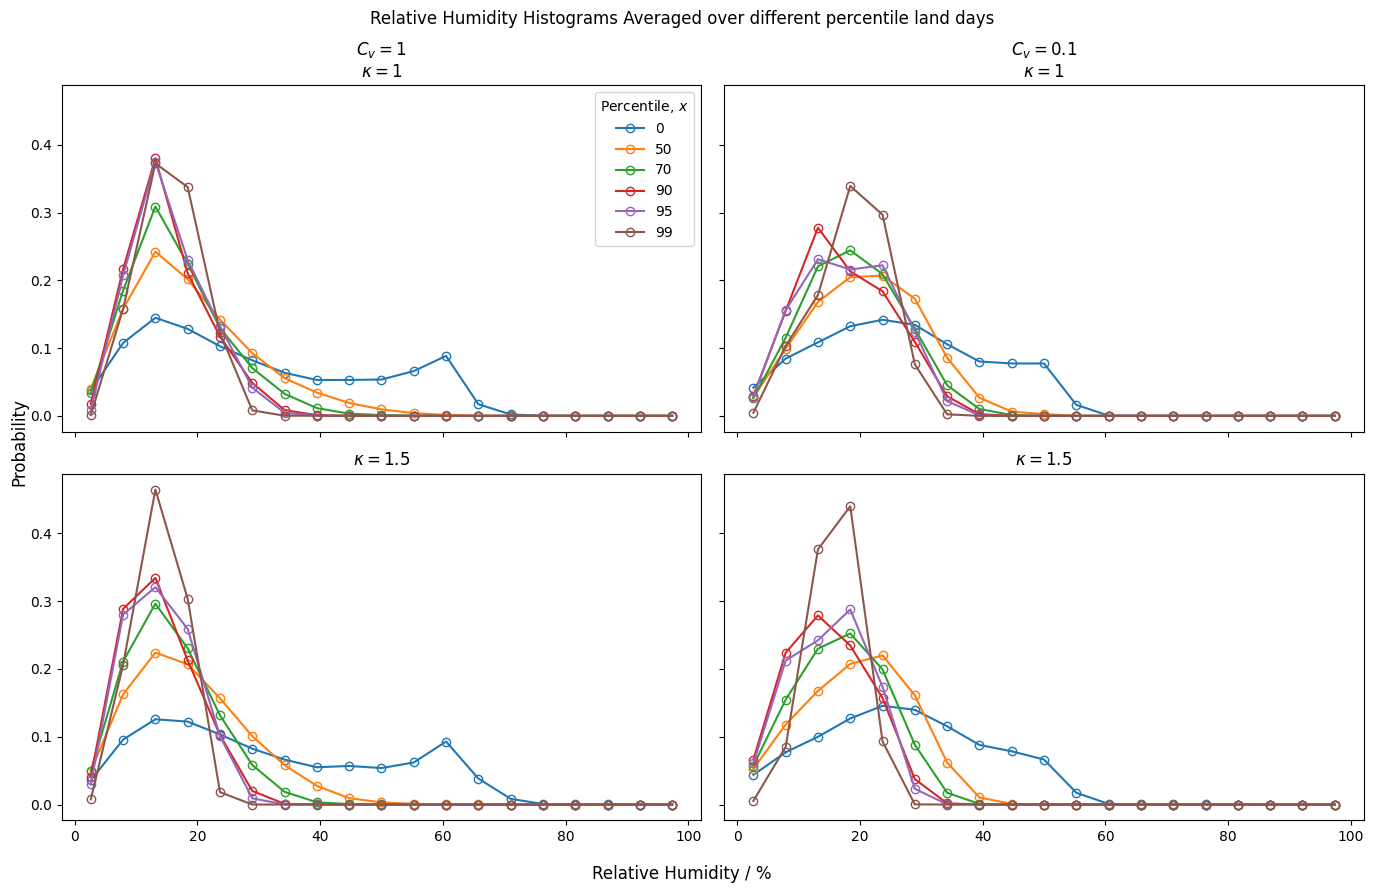

In [12]:
# Plot relative humidity histograms averaged over different quantiles of land surface temperature
# Have first bin be very narrow and centered on 0 so records amount of 0 bucket depths
rh_bins = np.linspace(0, 100, 20)
fig, ax = plt.subplots(n_kappa,n_evap, figsize=(14, 9), sharex=True, sharey=True)
for i in range(n_evap):
    for quant in quant_plot:
        for k in range(n_kappa):
            bin_counts = np.histogram(rh_all['land'][evap_ind[i][k]][
                                          get_quant_ind(ds_all['land'][evap_ind[i][k]], quant)], bins=rh_bins)[0]
            ax[k, i].plot(np.convolve(rh_bins, np.ones(2)/2, mode='valid'), bin_counts/np.sum(bin_counts),
                          marker='o', fillstyle='none', label=quant)
            if k == 0:
                ax[k, i].set_title(f"$C_v={evap_param[evap_ind[i][0]]}$\n$\kappa = {tau_lw[evap_ind[0][k]]}$")
            else:
                ax[k, i].set_title(f"$\kappa = {tau_lw[evap_ind[0][k]]}$")

ax[0, 0].legend(title='Percentile, $x$')
fig.supylabel('Probability')
fig.supxlabel('Relative Humidity / %')
fig.suptitle('Relative Humidity Histograms Averaged over different percentile land days')
plt.tight_layout();